<a href="https://colab.research.google.com/github/sophie-haynes/captum_optimviz/blob/optim-wip/tutorials/optimviz/patched/Patching_Weight_Visualisation_Demo_(Torch_Captum).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing weights with captum.optim

This notebook is a companion to [Visualizing Weights](https://distill.pub/2020/circuits/visualizing-weights), and demonstrates the use of the captum.optim submodule for visualizing the weights of the InceptionV1 model imported from Caffe.

In this tutorial we will walk you through how to use the captum.optim submodule to visualize neuron weights and the circuits that they are a part of. We will also see how to use non-negative matrix factorization (NMF) to visualize weights with more than 3 channel dimensions, and how to contextualize neurons with the use of expanded weights.

In [ ]:
!pip install tdqm

  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1321 sha256=6a2792ef69226f2d71803cf4a13d59c9d984ab3bf3706023f322d251bcbe36fc
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [ ]:
# !git clone https://github.com/pytorch/captum
!git clone https://github.com/sophie-haynes/captum_optimviz.git
# %cd captum
%cd captum_optimviz
!git checkout "optim-wip"
!pip3 install -e .
import sys
# sys.path.append('/content/captum')
sys.path.append('/content/captum_optimviz')
%cd ..

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')

Cloning into 'captum_optimviz'...
remote: Enumerating objects: 27818, done.
remote: Counting objects: 100% (2987/2987), done.
remote: Compressing objects: 100% (864/864), done.
remote: Total 27818 (delta 1627), reused 2754 (delta 1438), pack-reused 24831 (from 1)
Receiving objects: 100% (27818/27818), 282.94 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (16738/16738), done.
/content/captum_optimviz
Branch 'optim-wip' set up to track remote branch 'optim-wip' from 'origin'.
Switched to a new branch 'optim-wip'
Obtaining file:///content/captum_optimviz
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for captum (pyproject.toml) ... done
  Created wheel for captum: filename=captum-0.5.0-0.editable-py3-none-any.whl size=11890 sha256=fe5bf023ad914976a3bf01f3d920853d3985d3abb6616f73a335319e419f8193
  Stored in dir

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
# from captum.optim.models.inception_v1 import googlenet
from captum.optim.models import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

For convenience, we can create helper functions for visualizing the weights of our model.


In [ ]:
from typing import Callable, Dict, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

LossFunction = Callable[[Dict[torch.nn.Module, Optional[torch.Tensor]]], torch.Tensor]


def show(
    x: torch.Tensor, figsize: Optional[Tuple[int, int]] = None, scale: float = 255.0
) -> None:
    assert x.dim() == 3 or x.dim() == 4
    x = x[0] if x.dim() == 4 else x
    x = x.cpu().permute(1, 2, 0) * scale
    if figsize is not None:
        plt.figure(figsize=figsize)
    plt.imshow(x.numpy().astype(np.uint8))
    plt.axis("off")
    plt.show()


def vis_neuron_large(
    model: torch.nn.Module, target: torch.nn.Module, channel: int
) -> None:
    image = optimviz.images.NaturalImage((224, 224)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transforms.RandomSpatialJitter(16),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.CenterCrop((224, 224)),
    )
    loss_fn = optimviz.loss.NeuronActivation(target, channel)
    # obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    obj = optimviz.InputOptimization(model=model, input_param=image, transform=transforms,loss_function=loss_fn)
    # history = obj.optimize(optimviz.objectives.n_steps(128))
    history = obj.optimize(optimviz.optimization.n_steps(128))
    image().show()


def vis_neuron(
    model: torch.nn.Module, target: torch.nn.Module, loss_fn: LossFunction
) -> torch.Tensor:
    image = optimviz.images.NaturalImage((60, 60)).to(device)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(4),
        optimviz.transforms.RandomSpatialJitter(8),
        optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5, 5)),
        optimviz.transforms.RandomSpatialJitter(2),
        optimviz.transforms.CenterCrop((60, 60)),
    )
    # obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    obj = optimviz.InputOptimization(model=model, input_param=image, transform=transforms,loss_function=loss_fn)
    # history = obj.optimize(optimviz.objectives.n_steps(128, False))
    history = obj.optimize(optimviz.optimization.n_steps(128, False))
    # return image().T
    return image()


def visualize_neuron_list(
    model: torch.nn.Module, target: torch.nn.Module, neuron_list: List[int]
) -> List[torch.Tensor]:
    A = []
    for n in neuron_list:
        loss_fn = optimviz.loss.NeuronActivation(target, n)
        x_out = vis_neuron(model, target, loss_fn)
        A.append(x_out.detach())
    return A

## Extracting expanded weights

Context is everything when researching how neurons and their features work and interact with each other. Looking at individual weights alone doesn't give us the necessary context we need, so instead we often use what is called expanded weights. Expanded weights let us see meaningful interactions between neurons that aren’t literally adjacent in a neural network, and where features are spread across multiple neurons. To create expanded weights from a model, we will use Captum.optim's `extract_expanded_weights` function!

Expanded weights also allow us to see specialized algorithms that build features from their most basic parts into complex features. We call these specialized algorithms ‘circuits’, and by studying them we can learn a lot about how a neural network works.

**Non-linear operations**

Before creating expanded weights, we must ensure that any nonlinear operations in our model have been replaced with their linear equivalents. In the example below, we load the InceptionV1 model with it's nonlinear `nn.MaxPool2d` layers replaced with their linear `nn.AvgPool2d` equivalents. The nonlinear ReLU layers are also replaced with empty layers. This linear version of the model is only needed for collecting expanded weights.

**Collecting expanded weights**

Below we extract the 5 by 5 expanded weights from between the mixed3a and mixed3b layers. The output tensor is in the form of / has a shape of: `[target2 output channels, target1 output channels, height, width]`

In [ ]:
# Load InceptionV1 model with nonlinear layers replaced by their linear equivalents
linear_model = googlenet(pretrained=True, use_linear_modules_only=True).to(device).eval()

W_3a_3b = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.mixed3a, linear_model.mixed3b, 5)

# Visualizing expanded weights

To make it easier to understand what we are seeing, we can create a heatmap using Captum.optim's `weights_to_heatmap_2d` function. The `weights_to_heatmap_2d` function will by default use the color red to show excitatory parts of the weights, blue for inhibitory parts of the weights, and white for no excitation or inhibition.

By using our heatmap, we can visualize our newly collected expanded weights for channel 147 of mixed3a and channel 379 of mixed3b like so:

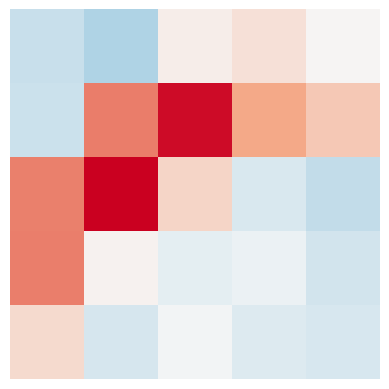

In [ ]:
W_3a_3b_hm = optimviz.weights_to_heatmap_2d(W_3a_3b[379, 147, ...] / W_3a_3b[379, ...].max())
show(W_3a_3b_hm)

By looking at the weights above, we can see how the following two curve detector neurons are connected to each other.

  0%|          | 0/128 [00:00<?, ? step/s]

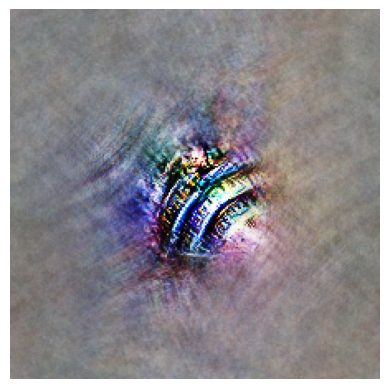

  0%|          | 0/128 [00:00<?, ? step/s]

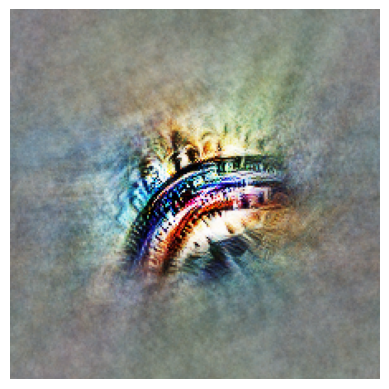

In [ ]:
vis_neuron_large(model, model.mixed3a, 147)
vis_neuron_large(model, model.mixed3b, 379)

# Top neuron connections

Expanded weights can also be used to see the top connections for a neuron.
Below we use expanded weights to see the top 10 Mixed3a neuron connections for the Mixed3b channel 379 neuron that we visualized above:

Top 10 Mixed3a neuron connections of Mixed3b channel 379 with 
the largest L2-norm: [95, 145, 147, 116, 77, 176, 187, 189, 87, 92] 


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1234: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1925.)
  return super().refine_names(names)


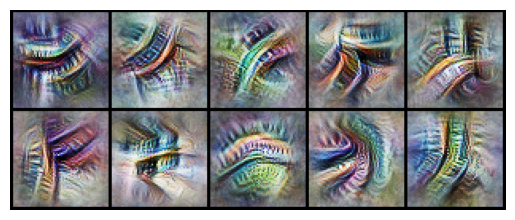

In [ ]:
top_connected_neurons = torch.argsort(
    torch.stack(
        [-torch.linalg.norm(W_3a_3b[379, i, :, :]) for i in range(W_3a_3b.shape[1])]
    )
)[:10]

print(
    "Top {} Mixed3a neuron connections of Mixed3b channel 379 with \nthe largest L2-norm: {} ".format(
        list(top_connected_neurons.size())[0], top_connected_neurons.tolist()
    )
)

A = visualize_neuron_list(model, model.mixed3a, top_connected_neurons)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

We can find the top Mixed4a neuron connections for the Mixed3b channel 379 neuron pretty easily as well. To avoid distortion of the weights, we use the pooling layer in between Mixed3b and Mixed4a as our starting point.

Top 10 Mixed4a neuron connections of Mixed3b channel 379 with 
the largest L2-norm: [50, 437, 96, 398, 434, 423, 408, 436, 424, 168] 


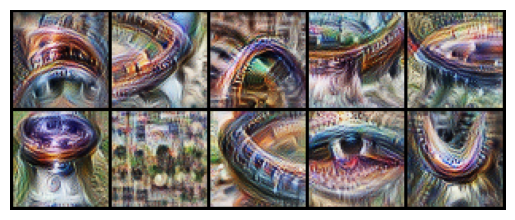

In [ ]:
W_p3_4a = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.pool3, linear_model.mixed4a, 5)

top_connected_neurons = torch.argsort(
    torch.stack(
        [-torch.linalg.norm(W_p3_4a[i, 379, :, :]) for i in range(W_p3_4a.shape[0])]
    )
)[:10]

print(
    "Top {} Mixed4a neuron connections of Mixed3b channel 379 with \nthe largest L2-norm: {} ".format(
        list(top_connected_neurons.size())[0], top_connected_neurons.tolist()
    )
)

A = visualize_neuron_list(model, model.mixed4a, top_connected_neurons)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

# Visualizing the spatial positions of expanded weights

As an alternative approach to visualizing neuron weights, we can treat the expanded weights as vectors and then use these vectors to steer the visualization process. This lets us see what the weights in each spatial position are looking for.

Below we visualize each of the 25 (5 by 5) spatial positions for expanded weights from Mixed3a and Mixed3b channel 379. The resulting images are then faded based on the strength of their corresponding weights, so that we can see the importance of each spatial position. If you look closely, you'll see that the spatial positions pattern of fading matches the heatmap we generated at the start of the tutorial!

In [9]:
def vis_spatial(
    vecs: torch.Tensor,
    model: torch.nn.Module,
    target: torch.nn.Module,
    show_magnitude: bool = True,
) -> torch.Tensor:
    assert vecs.dim() == 3
    vecs_flat = vecs.reshape([-1, vecs.shape[1] * vecs.shape[2]]).permute(1, 0)
    imgs = []
    for v in vecs_flat:
        loss_fn = optimviz.loss.NeuronDirection(target, vec=v)
        out = vis_neuron(model, target, loss_fn)
        imgs.append(out)
    imgs = torch.cat(imgs, 0)

    if show_magnitude:
        vh, vw = list(vecs.shape)[1:]
        ih, iw = list(imgs.shape)[2:]
        new_shape = [vh, vw] + list(imgs.shape)[1:]

        mags = torch.sqrt(torch.sum(vecs ** 2, 0))
        mags = mags.reshape([vh, vw] + [1, 1, 1]) / mags.max()

        imgs = imgs.reshape(new_shape) * mags + 0.9 * (1 - mags)
        imgs = imgs.reshape([vh * vw] + [3, ih, iw])
    return imgs

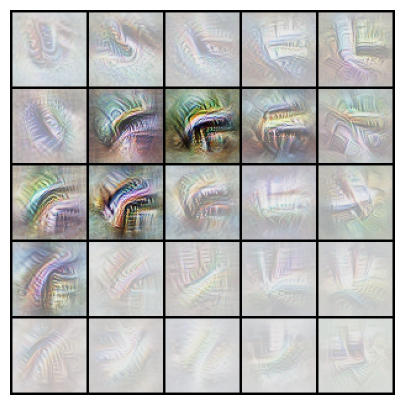

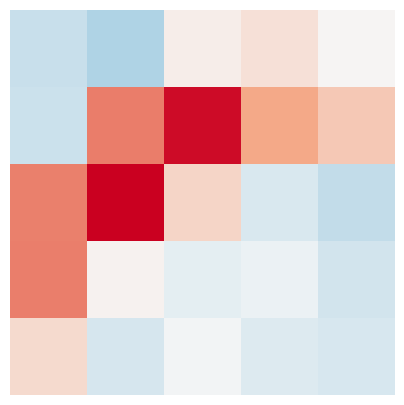

In [10]:
imgs = vis_spatial(W_3a_3b[379,:,:,:], model, model.mixed3a)
grid_img = torchvision.utils.make_grid(imgs.detach(), nrow=5)
show(grid_img, figsize=(5, 5))
show(W_3a_3b_hm, figsize=(5, 5))

# NMF Visualizations of expanded weights

[Non-negative matrix factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) (NMF) and other dimensionality reduction algorithms can be used to reveal the spatial structure of weights. Below we use one-sided NMF dimensionality reduction to collapse the input channels down to 3 dimensions so that we can view them as an RGB image. To make the NMF dimensionality reduction be one-sided, we apply Captum.optim's `posneg` function to make all values in the input positive.

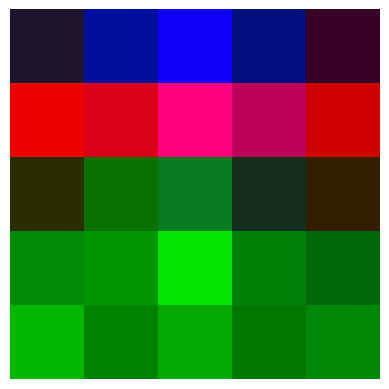

In [11]:
reducer = optimviz.reducer.ChannelReducer(3, "NMF")

# Make the input positive for one-sided NMF
W_3a_3b_posneg = optimviz.reducer.posneg(W_3a_3b, dim=1)

W_nmf = reducer.fit_transform(W_3a_3b_posneg[320, ...])
W_nmf = W_nmf / W_nmf.max()
show(W_nmf)

Using the weights above, we can see how that they match the structure of the target neurons when they are visualized.

  0%|          | 0/128 [00:00<?, ? step/s]

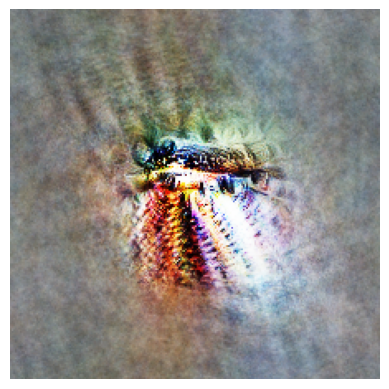

In [12]:
vis_neuron_large(model, model.mixed3b, 320)

Seeing how different neurons & their weights compare to each other can also be interesting.

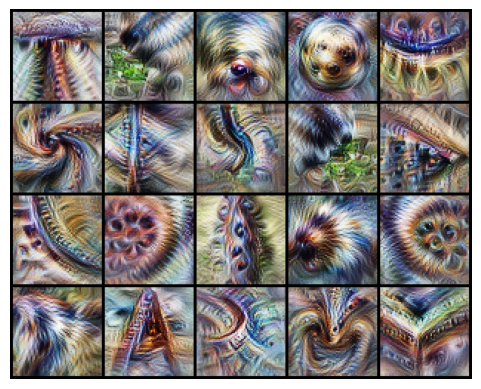

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


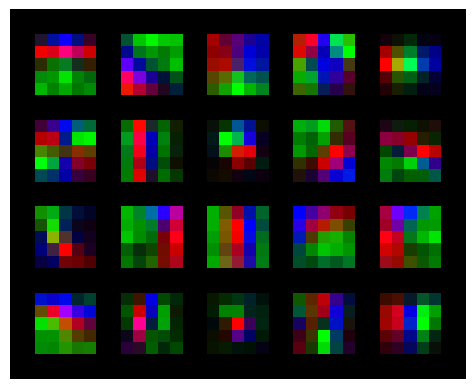

In [13]:
units = list(range(320, 340))

A = visualize_neuron_list(model, model.mixed3b, units)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

A = []
for i in units:
    W_nmf = reducer.fit_transform(W_3a_3b_posneg[i, ...])
    W_nmf = W_nmf / W_nmf.max()
    A.append(W_nmf)

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
show(grid_img)

### Weight banding

Below we see the effects of the global average pooling layer at the end of the InceptionV1 model on the final convolution layers' weights. This phenomenon is called weight banding, and we can see it by using NMF dimensionality reduction directly on the non-expanded weights. A detailed article on weight banding by Petrov et al. is forthcoming.

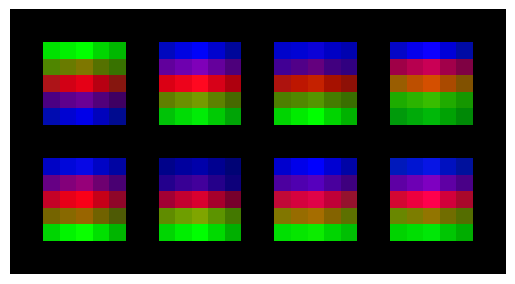

In [14]:
# Get model weights
W_5b_c5x5 = model.mixed5b.conv_5x5.weight.detach()

# Make the input positive for one-sided NMF
W_5b_c5x5_posneg = optimviz.reducer.posneg(W_5b_c5x5, dim=1)

A = []
for i in range(8):
    W_nmf = reducer.fit_transform(W_5b_c5x5_posneg[i, ...])
    W_nmf = W_nmf / W_nmf.max()
    A.append(W_nmf)

grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=4)
show(grid_img)

### Multiple related neurons with a small number of factors

One-sided NMF dimensionality reduction can also be used to describe multiple related neurons with a small number of factors.

Below we demonstrate this with [high-low frequency detectors](https://distill.pub/2020/circuits/frequency-edges/) (Schubert et al). The weights have one side / factor corresponding to high frequency and another to low. These two factors are arranged in different patterns for each neuron, and we can easily visualize them.

We can also visualize the weight analogue of “Neuron Groups” visualization from the [Building Blocks](https://distill.pub/2018/building-blocks/) research article. We do this by treating the two main factors as direction vectors.

In [16]:
W_p2_3a = optimviz.circuits.extract_expanded_weights(linear_model, linear_model.pool2, linear_model.mixed3a, 5)

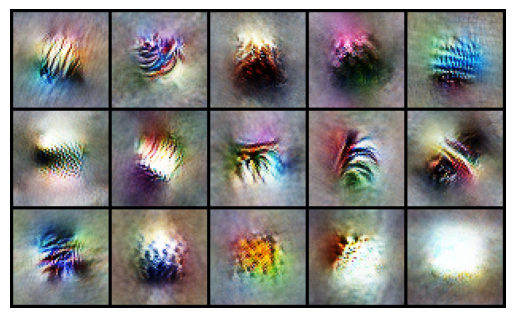

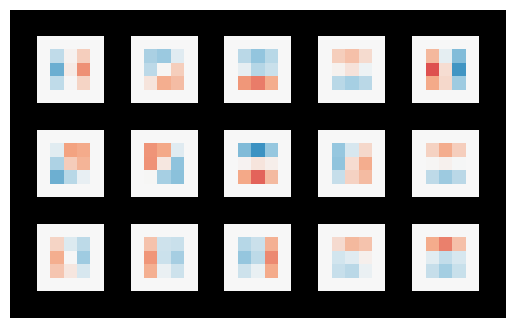

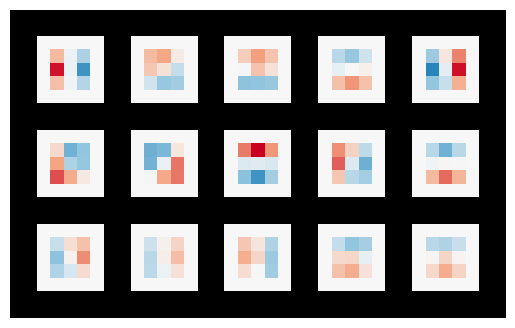

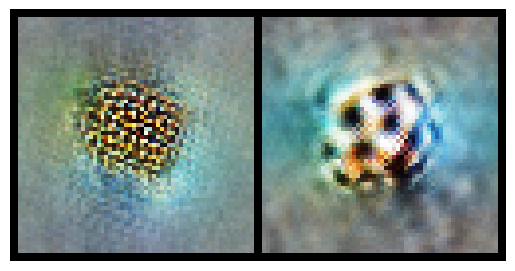

In [17]:
highlow_units = [110, 180, 153, 106, 112, 186, 132, 136, 117, 113, 108, 70, 86, 88, 160]

# Extract the units that we want to view
W_hl = W_p2_3a[highlow_units, ...]

# Make the input positive for one-sided NMF
W_posneg = optimviz.reducer.posneg(W_hl, dim=0)

# Reduce expanded-weights down to 2 factors
reducer = optimviz.reducer.ChannelReducer(2, "NMF")
W_nmf = reducer.fit_transform(W_posneg)

W_nmf = W_nmf / W_nmf.max()
W_nmf = W_nmf[:len(highlow_units)] - W_nmf[len(highlow_units):]

# Visualize high-low frequency detector neurons
A = visualize_neuron_list(model, model.conv3, highlow_units)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

# Visualize heatmaps for both components / factors
for n in range(2):
    A = []
    for i in range(len(highlow_units)):
        W_x = optimviz.weights_to_heatmap_2d(W_nmf[i, n, ...])
        A.append(W_x)

    grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=5)
    show(grid_img)

# Visualize both components / factors as direction vectors
A = []
for vec in reducer.components:
    loss_fn = optimviz.loss.NeuronDirection(model.conv3, vec)
    x_out = vis_neuron(model, model.conv3, loss_fn)
    A.append(x_out.detach())
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)

[Black and white vs color detectors](https://distill.pub/2020/circuits/early-vision/#group_mixed3a_bw_vs_color) are another example of multiple related neurons with a small number of factors:

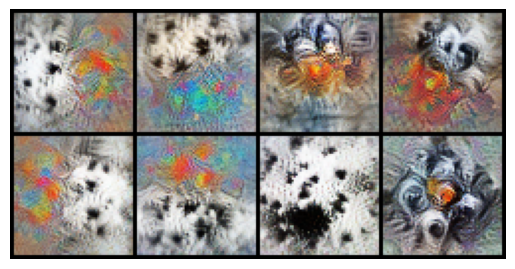

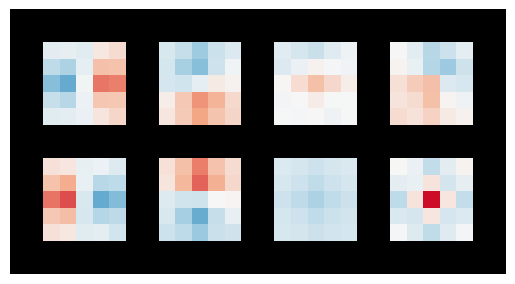

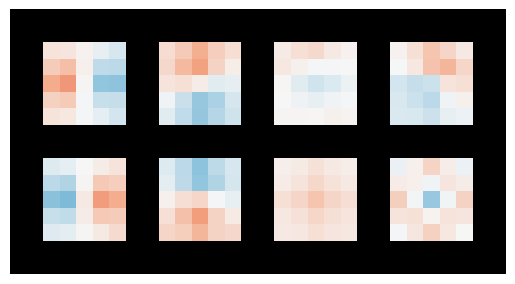

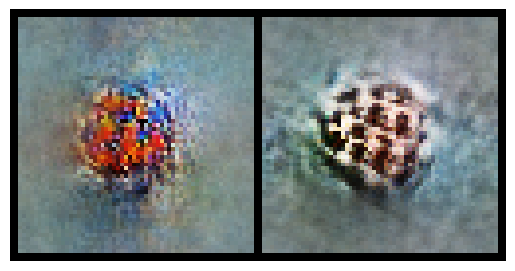

In [18]:
bw_units = [214, 208, 201, 223, 210, 197, 222, 204]

# Extract the units that we want to view
W_hl = W_p2_3a[bw_units, ...]

# Make the input positive for one-sided NMF
W_posneg = optimviz.reducer.posneg(W_hl, dim=0)

# Reduce expanded-weights down to 2 factors
reducer = optimviz.reducer.ChannelReducer(2, "NMF")
W_nmf = reducer.fit_transform(W_posneg)

W_nmf = W_nmf / W_nmf.max()
W_nmf = W_nmf[:len(bw_units)] - W_nmf[len(bw_units):]

# Visualize black and white color detector neurons
A = visualize_neuron_list(model, model.mixed3a, bw_units)
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=4)
show(grid_img)

# Visualize heatmaps for both components / factors
for n in range(2):
    A = []
    for i in range(len(bw_units)):
        W_x = optimviz.weights_to_heatmap_2d(W_nmf[i, n, ...])
        A.append(W_x)

    grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=4)
    show(grid_img)

# Visualize both components / factors as direction vectors
A = []
for vec in reducer.components:
    loss_fn = optimviz.loss.NeuronDirection(model.conv3, vec)
    x_out = vis_neuron(model, model.conv3, loss_fn)
    A.append(x_out.detach())
grid_img = torchvision.utils.make_grid(torch.cat(A), nrow=5)
show(grid_img)